## **Lab Assignment 4**


<font color='blue'>Objective: </font>

In this assignment, you will load and preprocess the Auto MPG dataset, addressing issues such as duplicates and missing values. You will implement a decision tree regressor from scratch, using Mean Squared Error (MSE) reduction for node splitting and tuning hyperparameters (maximum depth and minimum samples in leaf) through K-fold cross-validation. You will compare your implementation with scikit-learn’s decision tree regressor by evaluating and contrasting their MSE performance and hyperparameter values. Additionally, you will visualize the results with scatter plots of predicted versus true MPG values and a decision tree diagram.

### <font color='blue'> Task - 1 [Marks 0] </font>:
Load and preprocess the Auto [MPG dataset](https://archive.ics.uci.edu/dataset/9/auto+mpg) - there are 7 features and the target variable is the MPG of the car. Note that car id (string) is not a feature.


In [1]:
#Solution code

!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes)
X = auto_mpg.data.features
y = auto_mpg.data.targets

# metadata
print(auto_mpg.metadata)

# variable information
print(auto_mpg.variables)

{'uci_id': 9, 'name': 'Auto MPG', 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg', 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv', 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 398, 'num_features': 7, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['mpg'], 'index_col': ['car_name'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1993, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5859H', 'creators': ['R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for th

In [3]:
X.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


### <font color='blue'> Task - 2 [Marks 1] </font>:
:
1. Check for duplicate and missing features and handle such cases as necessary.  

2. Partition the data into training, and test sets (80%-20%).  

In [4]:
# Solution code

import pandas as pd

# Assuming X is a DataFrame and y is a Series

# Combine X and y into a single DataFrame
df = pd.concat([X, y], axis=1)

# Check for and remove duplicate rows in the combined DataFrame
df_cleaned = df.drop_duplicates()

# Split the cleaned DataFrame back into X and y
X_cleaned = df_cleaned.iloc[:, :-1]  # All columns except the last one
y_cleaned = df_cleaned.iloc[:, -1]   # The last column

# Optional: Reset index if needed
X_cleaned = X_cleaned.reset_index(drop=True)
y_cleaned = y_cleaned.reset_index(drop=True)

# Check if there are still duplicates
print(f"Number of duplicate rows in cleaned DataFrame: {df_cleaned.duplicated().sum()}")

Number of duplicate rows in cleaned DataFrame: 0


In [5]:
# Combine X and y into a single DataFrame
df = pd.concat([X, y], axis=1)

# Check for missing values in the combined DataFrame
missing_values = df.isnull().sum()
print("Missing values in the combined DataFrame:")
print(missing_values[missing_values > 0])

Missing values in the combined DataFrame:
horsepower    6
dtype: int64


In [6]:
df = df.dropna()

In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets (75% training, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [9]:
print(X_train.shape)  # (num_samples_train, num_features)
print(y_train.shape)  # (num_samples_train,)
print(X_test.shape)   # (num_samples_test, num_features)
print(y_test.shape)   # (num_samples_test,)

(318, 7)
(318, 1)
(80, 7)
(80, 1)


In [10]:
# Convert y_train, y_val, and y_test to 1D NumPy arrays
y_train = y_train.ravel()  # or y_train.squeeze()
y_test = y_test.ravel()    # or y_test.squeeze()

### <font color='blue'> Task - 3 [Marks 6] </font>:
Implement a decision tree regressor from scratch, where the decision tree algorithm you create will use Mean Squared Error (MSE) reduction as the criterion for splitting nodes.

In [11]:
import numpy as np

class CART(object):
    def __init__(self, criterion='mse', prune='depth', max_depth=4, min_samples_leaf=1, min_criterion=0.05):
        # Initialize the Decision Tree parameters for regression
        self.feature = None        # Index of the feature used for splitting
        self.label = None          # Value for leaf nodes (mean of target values)
        self.n_samples = None      # Number of samples in the node
        self.gain = None           # Information gain from the split
        self.left = None           # Left subtree
        self.right = None          # Right subtree
        self.threshold = None      # Threshold for splitting
        self.depth = 0             # Depth of the current node

        self.root = None           # Root node of the tree
        self.criterion = criterion # Criterion for splitting ('mse')
        self.prune = prune         # Pruning method ('depth')
        self.max_depth = max_depth # Maximum depth of the tree
        self.min_samples_leaf = min_samples_leaf # Minimum number of samples in a leaf
        self.min_criterion = min_criterion # Minimum criterion for pruning

    def fit(self, features, target):
        # Fit the decision tree to the data for regression
        self.root = CART(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
        self.root._grow_tree(features, target)
        self.root._prune(self.prune, self.max_depth, self.min_criterion, self.root.n_samples)

    def predict(self, features):
        # Predict the value for each feature set
        return np.array([self.root._predict(f) for f in features])

    def print_tree(self):
        # Print the tree structure
        self.root._show_tree(0, ' ')

    def _grow_tree(self, features, target):
        # Grow the tree by splitting nodes based on the criterion
        self.n_samples = features.shape[0]

        # If only one unique target value is present, set as leaf node
        if len(np.unique(target)) == 1:
            self.label = target[0]
            return

        best_gain = 0.0
        best_feature = None
        best_threshold = None

        # Initialize label for the node
        self.label = np.mean(target)

        impurity_node = self._calc_impurity(target)

        # Iterate over all features and possible thresholds to find the best split
        for col in range(features.shape[1]):
            feature_values = np.unique(features[:, col])
            thresholds = (feature_values[:-1] + feature_values[1:]) / 2.0

            for threshold in thresholds:
                target_l = target[features[:, col] <= threshold]
                target_r = target[features[:, col] > threshold]

                # Apply min_samples_leaf constraint
                if len(target_l) < self.min_samples_leaf or len(target_r) < self.min_samples_leaf:
                    continue

                impurity_l = self._calc_impurity(target_l)
                n_l = float(target_l.shape[0]) / self.n_samples

                impurity_r = self._calc_impurity(target_r)
                n_r = float(target_r.shape[0]) / self.n_samples

                impurity_gain = impurity_node - (n_l * impurity_l + n_r * impurity_r)
                if impurity_gain > best_gain:
                    best_gain = impurity_gain
                    best_feature = col
                    best_threshold = threshold

        self.feature = best_feature
        self.gain = best_gain
        self.threshold = best_threshold
        self._split_tree(features, target)

    def _split_tree(self, features, target):
        # Split the node into left and right subtrees
        features_l = features[features[:, self.feature] <= self.threshold]
        target_l = target[features[:, self.feature] <= self.threshold]
        self.left = CART(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
        self.left.depth = self.depth + 1
        self.left._grow_tree(features_l, target_l)

        features_r = features[features[:, self.feature] > self.threshold]
        target_r = target[features[:, self.feature] > self.threshold]
        self.right = CART(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
        self.right.depth = self.depth + 1
        self.right._grow_tree(features_r, target_r)

    def _calc_impurity(self, target):
        # Calculate the impurity of a node for regression
        return np.mean((target - np.mean(target)) ** 2.0)

    def _prune(self, method, max_depth, min_criterion, n_samples):
        # Prune the tree based on the specified method
        if self.feature is None:
            return

        self.left._prune(method, max_depth, min_criterion, n_samples)
        self.right._prune(method, max_depth, min_criterion, n_samples)

        pruning = False

        if method == 'depth' and self.depth >= max_depth:
            pruning = True
        elif method == 'impurity' and self.left.feature is None and self.right.feature is None:
            if (self.gain * float(self.n_samples) / n_samples) < min_criterion:
                pruning = True

        if pruning is True:
            self.left = None
            self.right = None
            self.feature = None

    def _predict(self, d):
        # Predict the value for a single data point
        if self.feature is not None:
            if d[self.feature] <= self.threshold:
                return self.left._predict(d)
            else:
                return self.right._predict(d)
        else:
            return self.label

    def _show_tree(self, depth, cond):
        # Print the tree structure
        base = '    ' * depth + cond
        if self.feature is not None:
            print(base + 'if X[' + str(self.feature) + '] <= ' + str(self.threshold))
            self.left._show_tree(depth + 1, 'then ')
            self.right._show_tree(depth + 1, 'else ')
        else:
            print(base + '{value: ' + str(self.label) + ', samples: ' + str(self.n_samples) + '}')

In [12]:
cart_regressor = CART(criterion='mse', prune='depth', max_depth=4, min_samples_leaf=1, min_criterion=0.1)
cart_regressor.fit(X_train, y_train)

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
predictions = cart_regressor.predict(X_test)

In [15]:
# Calculate performance metrics
mse = mean_squared_error(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 11.843371381736398


### <font color='blue'> Task - 4 [Marks 4] </font>:

Treat the maximum depth of the tree and the minimum samples in leaf (same as scikit-learn's min_samples_leaf) as hyperparameters and find the best values of the hyperparmeters by performing K-fold cross validation with grid search on the 80% samples from the training set. You can use **KFold** for this purpose. Perform predictions on the test set using the learned decision tree regressor and report the MSE on the test set.


In [16]:
# Solution code

from sklearn.model_selection import KFold

def cross_validate_params(max_depth, min_samples_leaf, features, target, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    mse_scores = []

    for train_index, val_index in kf.split(features):
        X_train, X_val = features[train_index], features[val_index]
        y_train, y_val = target[train_index], target[val_index]

        # Initialize the CART tree with the given depth
        model = CART(max_depth=max_depth, )
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)

        # Compute MSE
        mse = np.mean((y_val - predictions) ** 2)
        mse_scores.append(mse)

    return np.mean(mse_scores)


In [17]:
depths = [1, 2, 3, 4, 5]  # Example depths
min_samples = [1, 2, 5, 10]  # Example min_samples_leaf values
results = {}

for depth in depths:
    for min_samples_leaf in min_samples:
        mse = cross_validate_params(depth, min_samples_leaf, X_train, y_train)
        results[(depth, min_samples_leaf)] = mse

print("Cross-Validation Results:")
for (depth, min_samples_leaf), mse in results.items():
    print(f"Depth {depth}, Min Samples Leaf {min_samples_leaf}: MSE = {mse:.4f}")

# Optionally, find the best combination
best_params = min(results, key=results.get)
print(f"Best parameters: Depth {best_params[0]}, Min Samples Leaf {best_params[1]} with MSE = {results[best_params]:.4f}")

Cross-Validation Results:
Depth 1, Min Samples Leaf 1: MSE = 28.0920
Depth 1, Min Samples Leaf 2: MSE = 28.0920
Depth 1, Min Samples Leaf 5: MSE = 28.0920
Depth 1, Min Samples Leaf 10: MSE = 28.0920
Depth 2, Min Samples Leaf 1: MSE = 19.9102
Depth 2, Min Samples Leaf 2: MSE = 19.9102
Depth 2, Min Samples Leaf 5: MSE = 19.9102
Depth 2, Min Samples Leaf 10: MSE = 19.9102
Depth 3, Min Samples Leaf 1: MSE = 14.7027
Depth 3, Min Samples Leaf 2: MSE = 14.7027
Depth 3, Min Samples Leaf 5: MSE = 14.7027
Depth 3, Min Samples Leaf 10: MSE = 14.7027
Depth 4, Min Samples Leaf 1: MSE = 12.8843
Depth 4, Min Samples Leaf 2: MSE = 12.8843
Depth 4, Min Samples Leaf 5: MSE = 12.8843
Depth 4, Min Samples Leaf 10: MSE = 12.8843
Depth 5, Min Samples Leaf 1: MSE = 15.1191
Depth 5, Min Samples Leaf 2: MSE = 15.1191
Depth 5, Min Samples Leaf 5: MSE = 15.1191
Depth 5, Min Samples Leaf 10: MSE = 15.1191
Best parameters: Depth 4, Min Samples Leaf 1 with MSE = 12.8843


### <font color='blue'> Task - 5 [Marks 3] </font>:

Fit the decision tree regressor model on the training set using scikit learn. Also, perform the cross validation and find the best values of the two hyperparameters in the same way as explained in case of the from scratch implementation.  

In [18]:
# Solution code

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Initialize and fit the Decision Tree Regressor
tree_regressor = DecisionTreeRegressor(max_depth=4)  # Example max_depth
tree_regressor.fit(X_train, y_train)

# Predict on training data (or test data if available)
predictions = tree_regressor.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 17.264390931821314


### <font color='blue'> Task - 6 [Marks 2] </font>:
Compare whether the best hyperparameter values similar for *your* implementation and scikit-learn? Also, compare the MSE obtained by your implementation with that given by scikit-learn.

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the parameter grid
param_grid = {
    'max_depth': [1, 2, 3, 4, 5],  # Example depths
    'min_samples_leaf': [1, 2, 5, 10]  # Example minimum samples per leaf
}

# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor()

# Initialize GridSearchCV with k-fold cross-validation
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Predict using the best model
predictions_best = best_model.predict(X_test)

# Compute MSE using the best model
mse_best = mean_squared_error(y_test, predictions_best)
print(f"Mean Squared Error (MSE) with Best Model: {mse_best}")


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 10}
Best Score (Negative MSE): -17.58360308203499
Mean Squared Error (MSE) with Best Model: 15.36990030979361


### <font color='blue'> Task - 7 [Marks 2] </font>:
Show the scatter plots of predicted mpg vs. True mpg for both the from scratch implementation and scikit-learn's implementation of decision tree regressor.  

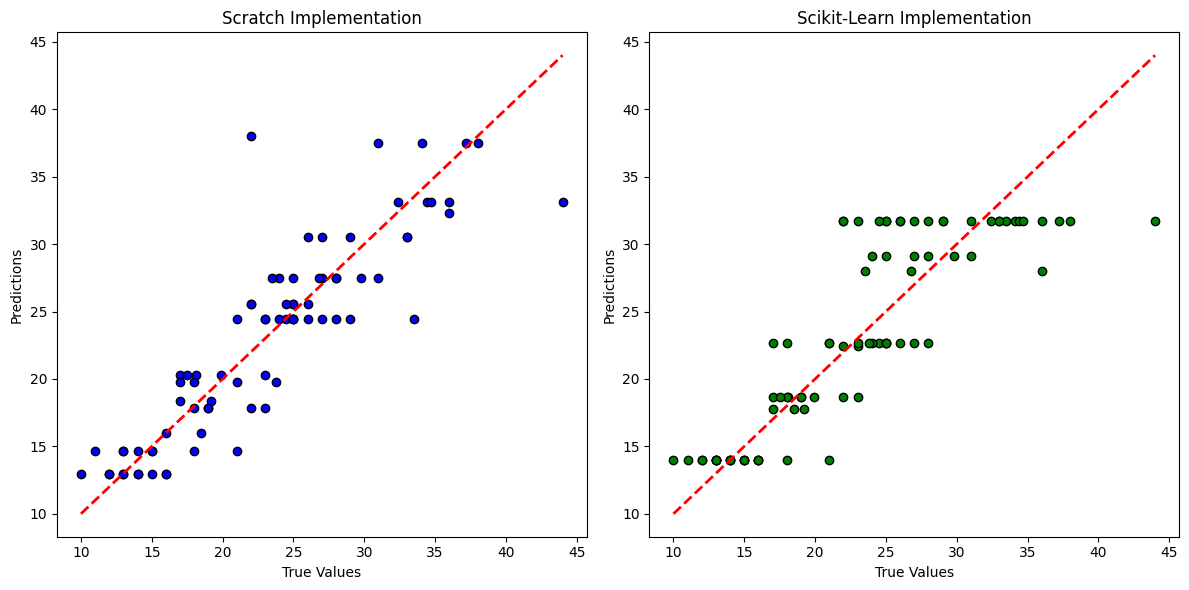

In [20]:
# Solution ccode

# Using your scratch implementation
scratch_predictions = cart_regressor.predict(X_test)

# Predictions using the scikit-learn model
sklearn_predictions = best_model.predict(X_test)  # Replace with your fitted scikit-learn model

import matplotlib.pyplot as plt

# Scatter plot for scratch implementation
plt.figure(figsize=(12, 6))

# Plot for scratch implementation
plt.subplot(1, 2, 1)
plt.scatter(y_test, scratch_predictions, color='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scratch Implementation')

# Plot for scikit-learn implementation
plt.subplot(1, 2, 2)
plt.scatter(y_test, sklearn_predictions, color='green', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scikit-Learn Implementation')

plt.tight_layout()
plt.show()

### <font color='blue'> Task - 8 [Marks 2] </font>:
Show the visualization of the decision tree learned by scikit-learn.

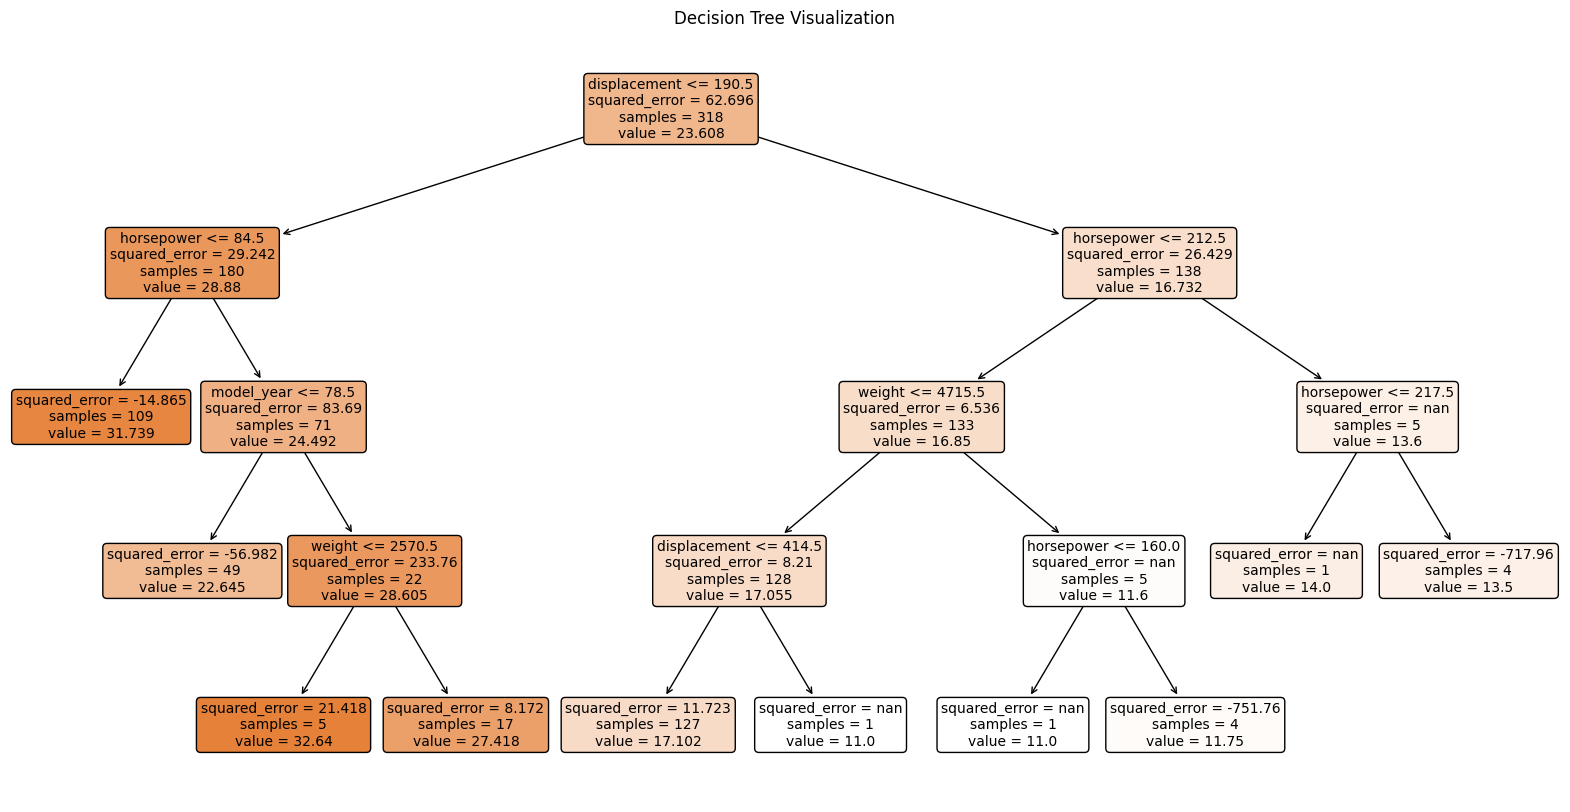

In [ ]:
# solution code

from sklearn.tree import plot_tree

# Assuming 'best_model' is your fitted DecisionTreeRegressor from scikit-learn
plt.figure(figsize=(20, 10))  # Adjust the size as needed
plot_tree(best_model,
          feature_names=['displacement',	'cylinders',	'horsepower',	'weight',	'acceleration',	'model_year',	'origin'],  # Replace with your actual feature names
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()